In [1]:
import pandas as pd
import sqlalchemy

# Paramètres de connexion à la base de données SQL Server
server = 'DESKTOP-NTA9A3K'  # Remplace par le vrai nom de ton serveur
database = 'DW_PI7'  # Remplace par le nom de ta base de données
driver = 'ODBC Driver 17 for SQL Server'  # Assure-toi que ce driver est installé

# Création de l'engine SQLAlchemy pour se connecter à la base de données
engine = sqlalchemy.create_engine(f"mssql+pyodbc://{server}/{database}?trusted_connection=yes&driver={driver}")

# Vérifier la connexion et charger les données
with engine.connect() as conn:
    # Charger la table de faits
    query_facts = "SELECT * FROM fact_date2"
    df = pd.read_sql(query_facts, conn)

    # Charger les tables de dimensions
    query_dim_bac = "SELECT * FROM Dim_Bac"
    query_dim_candidat = "SELECT * FROM Dim_Candidat"
    query_dim_gouvernorat = "SELECT * FROM Dim_Gouvernorat"
    query_dim_pays = "SELECT * FROM Dim_Payss"
    query_dim_dossiers = "SELECT * FROM Dim_Dossiers"
    query_dim_diplome = "SELECT * FROM Dim_Diplome"
    query_dim_concour = "SELECT * FROM Dim_Concour"
    query_dim_date = "SELECT * FROM Dim_date"

    dim_bac = pd.read_sql(query_dim_bac, conn)
    dim_candidat = pd.read_sql(query_dim_candidat, conn)
    dim_gouvernorat = pd.read_sql(query_dim_gouvernorat, conn)
    dim_pays = pd.read_sql(query_dim_pays, conn)
    dim_dossiers = pd.read_sql(query_dim_dossiers, conn)
    dim_diplome= pd.read_sql(query_dim_diplome, conn)
    dim_concour = pd.read_sql(query_dim_concour, conn)
    dim_date = pd.read_sql(query_dim_date, conn)





# Vérification des données fusionnées
print(df.head())

   Candidature_Pk  Dossier_Pk  Candidat_pk  Gouv_PK  Pays_Pk  Diplome_Pk  \
0             113        1773          113       17       32           0   
1             125        1936          125        7       32           0   
2             169         169          169       13       32           0   
3             258         258          258       10       32           0   
4             302         302          302       16       32           0   

   Concours_Pk  Bac_Pk  Date_Pk1  Date_Pk2  Date_Pk3  Date_Pk4  Date_Pk5  \
0           39       2  20220724  20230808  20230811  20230815  20220812   
1           41       3  20220722  20210814  20210801  20210805  20220726   
2           43       1  20220721  20210806  20210811  20210815  20220706   
3           37       6  20220717  20220811  20230801  20230805  20220709   
4           43      10  20220717  20210806  20210811  20210815  20220806   

   score_final  moy_bac_et  Admission  
0        95.35       14.50          0  
1     

In [3]:
print(df['Date_Pk4'].unique()[:10])


[20230815 20210805 20210815 20230805 20220820 20230820 20200815 20230810
 20210810 20200805]


In [5]:
df['Date_Pk4'] = df['Date_Pk4'].astype(str)
df = df[df['Date_Pk4'].str.match(r'^\d{8}$')]


In [7]:
df['date_resultat'] = pd.to_datetime(df['Date_Pk4'], format='%Y%m%d')



In [1]:
# Exemple par mois :
df.set_index('date_resultat', inplace=True)

# Score moyen par mois
df_monthly = df.resample('M')['score_final'].mean()

# Ou médian :
# df_monthly = df.resample('M')['score_final'].median()


NameError: name 'df' is not defined

In [13]:
print(df_monthly.shape)
print(df_monthly.head(10))


(37,)
date_resultat
2020-08-31    53.831827
2020-09-30          NaN
2020-10-31          NaN
2020-11-30          NaN
2020-12-31          NaN
2021-01-31          NaN
2021-02-28          NaN
2021-03-31          NaN
2021-04-30          NaN
2021-05-31          NaN
Freq: ME, Name: score_final, dtype: float64


In [15]:
# Convertir Date_Pk4 si ce n’est pas fait
df['Date_Pk4'] = df['Date_Pk4'].astype(str)
df = df[df['Date_Pk4'].str.match(r'^\d{8}$')]
df['date_resultat'] = pd.to_datetime(df['Date_Pk4'], format='%Y%m%d')

# Réindexer
df.set_index('date_resultat', inplace=True)


C:\Users\user\AppData\Local\Temp\ipykernel_21172\536409722.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df['score_final'].resample('M').mean().dropna()


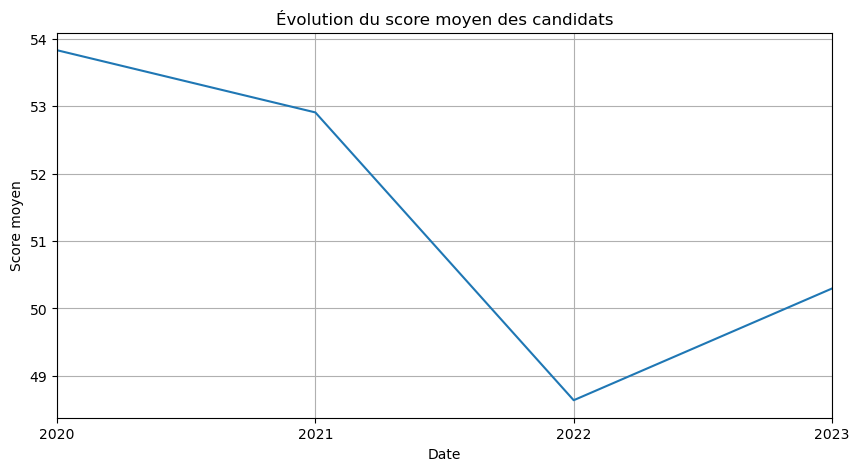

In [17]:
df_monthly = df['score_final'].resample('M').mean().dropna()

df_monthly.plot(title='Évolution du score moyen des candidats', figsize=(10,5))
plt.xlabel("Date")
plt.ylabel("Score moyen")
plt.grid(True)
plt.show()


In [19]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_monthly.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: -1.040667861485074
p-value: 0.7381442776912791


In [20]:
df_stationary = df_monthly.diff().dropna()


In [23]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA(p,d,q) - à ajuster avec auto_arima ou essais
model = ARIMA(df_monthly, order=(1,1,1))
model_fit = model.fit()
model_fit.summary()


C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YE-AUG will be used.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YE-AUG will be used.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YE-AUG will be used.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.p

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            score_final   No. Observations:                    4
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  -7.174
Date:                Thu, 24 Apr 2025   AIC                             20.348
Time:                        15:20:48   BIC                             17.644
Sample:                    08-31-2020   HQIC                            14.912
                         - 08-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6676     37.233      0.018      0.986     -72.307      73.642
ma.L1         -0.9973   2405.931     -0.000      1.000   -4716.536    4714.542
sigma2         5.9939   1.42e+04      0.000      1.000   -2.79e+04    2.79e+04
===================================================================================
Ljung-Box (L1) (Q):                   2.72   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.10   Prob(JB):                         0.83
Heteroskedasticity (H):                nan   Skew:                            -0.41
Prob(H) (two-sided):                   nan   Kurtosis:                         1.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

2024-08-31    50.776493
2025-08-31    51.097302
2026-08-31    51.311488
2027-08-31    51.454488
2028-08-31    51.549961
2029-08-31    51.613703
Freq: YE-AUG, Name: predicted_mean, dtype: float64


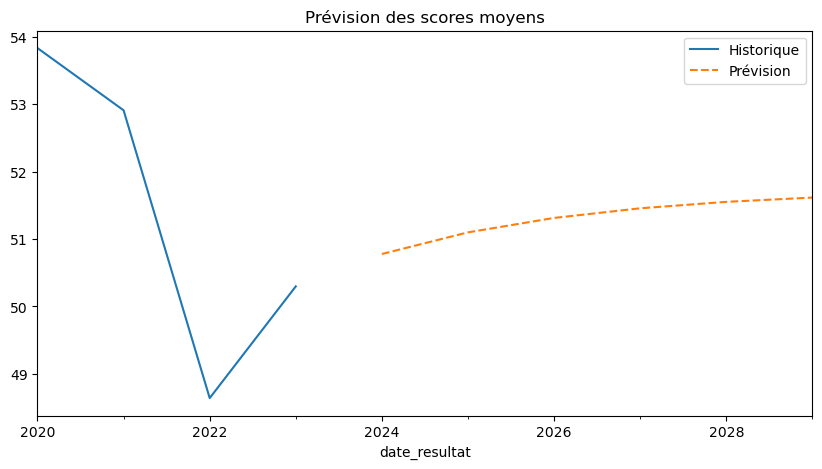

In [49]:
forecast = model_fit.forecast(steps=6)
print(forecast)

# Visualisation
df_monthly.plot(label='Historique', figsize=(10,5))
forecast.plot(label='Prévision', linestyle='--')
plt.legend()
plt.title("Prévision des scores moyens")
plt.show()


In [51]:
print(df_export.columns)


Index(['Historique', 'Prévision'], dtype='object')


In [55]:
# Prévision - forecast est déjà une série
prevision_df = pd.DataFrame({
    'date_resultat': forecast.index,
    'score_moyen': forecast.values,
    'type': 'Prévision'
})
# Convertir en float et arrondir
prevision_df['score_moyen'] = pd.to_numeric(prevision_df['score_moyen'], errors='coerce').round(2)


In [57]:
# Export uniquement des prévisions
prevision_df.to_csv("previsions_seules.csv", index=False)

# Ou concaténer avec les historiques
df_export = pd.concat([historique_df, prevision_df])
df_export.to_csv("scores_moyens_avec_prevision.csv", index=False)


In [59]:
# Convertir et arrondir la colonne 'score_moyen' en format décimal pour les deux DataFrames
historique_df['score_moyen'] = pd.to_numeric(historique_df['score_moyen'], errors='coerce').round(2)
prevision_df['score_moyen'] = pd.to_numeric(prevision_df['score_moyen'], errors='coerce').round(2)


In [61]:
# Fusionner les deux dans un seul DataFrame
df_export = pd.concat([historique_df, prevision_df])

# Exporter vers un fichier CSV
df_export.to_csv("scores_moyens_avec_prevision19.csv", index=False)


In [27]:
# 1. Importer les librairies
import pandas as pd
import matplotlib.pyplot as plt

# 2. Charger les données (à adapter selon ton cas)
df = pd.read_sql("SELECT * FROM fact_date2", engine)

# 3. Filtrer les dates au bon format (8 chiffres YYYYMMDD)
df = df[df['Date_Pk4'].astype(str).str.match(r'^\d{8}$')]

# 4. Transformer en datetime
df['date_resultat'] = pd.to_datetime(df['Date_Pk4'], format='%Y%m%d')


In [29]:
# 1. Importer les librairies
import pandas as pd
import matplotlib.pyplot as plt

# 2. Charger les données (à adapter selon ton cas)
df = pd.read_sql("SELECT * FROM fact_date2", engine)

# 3. Filtrer les dates au bon format (8 chiffres YYYYMMDD)
df = df[df['Date_Pk4'].astype(str).str.match(r'^\d{8}$')]

# 4. Transformer en datetime
df['date_resultat'] = pd.to_datetime(df['Date_Pk4'], format='%Y%m%d')


In [31]:
# 5. Mettre la date en index
df.set_index('date_resultat', inplace=True)

# 6. Vérifier les valeurs nulles
df = df[df['score_final'].notna()]


In [45]:
df_yearly = df['score_final'].resample('YE').mean()


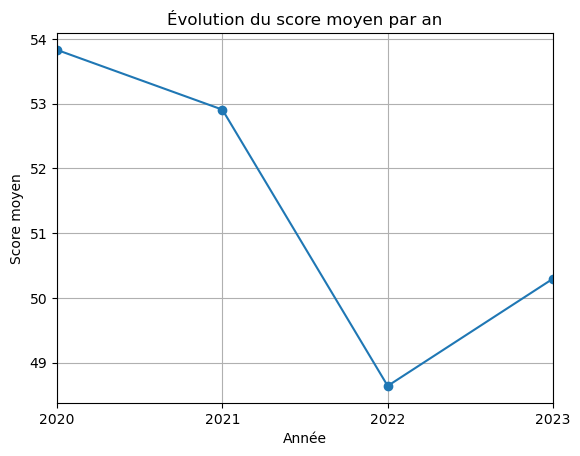

In [35]:
df_yearly.plot(title="Évolution du score moyen par an", marker='o')
plt.xlabel("Année")
plt.ylabel("Score moyen")
plt.grid(True)
plt.show()


In [47]:
from statsmodels.tsa.arima.model import ARIMA

# 8. Créer et ajuster le modèle ARIMA (1,1,1) par exemple
model = ARIMA(df_yearly, order=(1,1,1))
model_fit = model.fit()

# 9. Faire une prévision pour les 5 prochaines années
forecast = model_fit.get_forecast(steps=5)
forecast_index = pd.date_range(start=df_yearly.index[-1] + pd.DateOffset(years=1), periods=5, freq='YE')
forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)


C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


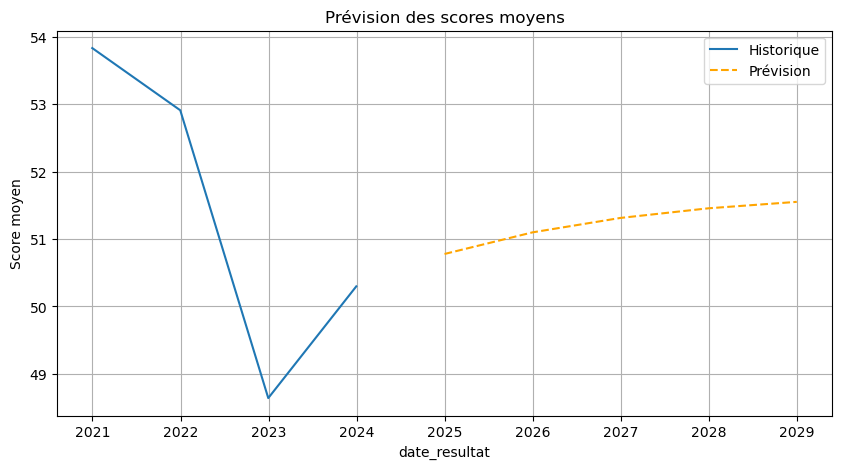

In [39]:
plt.figure(figsize=(10,5))
plt.plot(df_yearly, label="Historique")
plt.plot(forecast_series, label="Prévision", linestyle='--', color='orange')
plt.title("Prévision des scores moyens")
plt.xlabel("date_resultat")
plt.ylabel("Score moyen")
plt.legend()
plt.grid(True)
plt.show()


In [41]:
!pip install tensorflow scikit-learn


In [57]:
import numpy as np

# Forcer les mêmes colonnes et types
df_hist = df_hist[['Date', 'Score_Moyen']].copy()
df_hist['Prévision'] = np.nan  # Bien initialiser

df_forecast = df_forecast[['Date', 'Score_Moyen', 'Prévision']].copy()

# Maintenant concat propre
df_combined = pd.concat([df_hist, df_forecast], ignore_index=True).sort_values(by='Date')


C:\Users\user\AppData\Local\Temp\ipykernel_12388\18211302.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_hist, df_forecast], ignore_index=True).sort_values(by='Date')


In [59]:
df_combined.to_csv("serie_prevision_scores.csv", index=False)
